# The DistributionLambda Layer

> In this post, we will introduce the most direct way of incorporating distribution object into a deep learning model with distribution lambda layer. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/distributionlambda_layer.png

## Packages

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Linear model with Sequential API

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(1, input_shape=(2, ))
])

model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_train, y_train, epochs=10)

# y = <x, w> + b + eps
# eps ~ N(0, sigma^2)

# Likelihood
# theta = (w, b)
# theta^* = argmax_{theta} P(D | theta)
```

### DistributionLambda Layer in Linear Model

```python
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(1, input_shape=(2, )),
    # Final layer includes normal distribution
    # Form is a sort of Lambda function, that can give the output as a mean
    # in this case, output tensor is go through normal distribution
    # And normal distriubiton is trainable
    tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1)
    )
])
```

### Loss function for Distritubion Object
Negative Log-Likelihood Loss function
```python
def nll(y_true, y_pred):
    # Since y_pred is distribution object, we can call log_prob for sample data
    return -y_pred.log_prob(y_true)
```

### Converting Tensor function
In this case, output will be tensor object, not distribution object.
```python
model = Sequential([
    Dense(1, input_shape=(2, )),
    tfpl.DistributionLambda(
        lambda t:tfd.Normal(loc=t, scale=1),
        convert_to_tensor_fn=tfd.Distribution.sample
    )
])
# tfd.Distribution.mean
# tfd.Distribution.mode
```

### Example

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_shape=(12, )),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(logits=t))
])

In [5]:
model(np.ones((3, 12), dtype=np.float32)).sample(5)

<tf.Tensor: shape=(5, 3, 8), dtype=int32, numpy=
array([[[0, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1]],

       [[0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 0]],

       [[0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0]],

       [[1, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 1, 1]],

       [[1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0]]], dtype=int32)>

Its input layer has 8 nodes and passes through the distributionLambda layer. So its event_shape has 8. And input data is entered as 3 batches. We generate 5 samples. As a result, the output tensor shape will be `(5, 3, 8)`.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________


## Tutorial 

### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

In [20]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(units=1, input_shape=(1, ), activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0))
], name='deterministic_sigmoid_model')

In [21]:
model.summary()

Model: "deterministic_sigmoid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


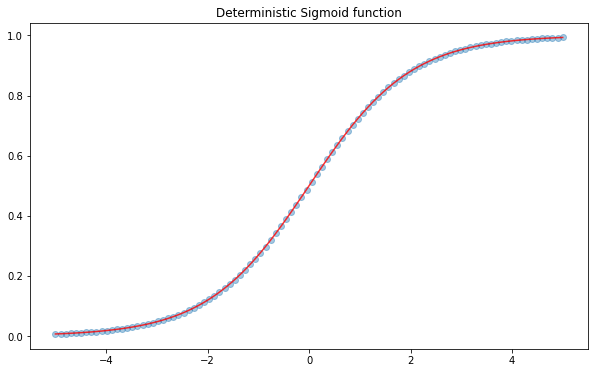

In [22]:
# Plot the deterministic model
X = np.linspace(-5, 5, 100)
plt.scatter(X, model.predict(X), alpha=0.4)
plt.plot(X, 1 / (1 + np.exp(-X)), color='r', alpha=0.8)
plt.title('Deterministic Sigmoid function')
plt.show()

In [17]:
# Create a constant input for this model
x = np.array([[0]])
x

array([[0]])

In [18]:
# Explore the feedforward object
y = model(x)
y

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [19]:
# ... and its behavior under repeated calls
for _ in range(5):
    print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


In [23]:
model = Sequential([
    Dense(units=1, input_shape=(1, ), activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)
], name='probabilistic_sigmoid_model')

model.summary()

Model: "probabilistic_sigmoid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


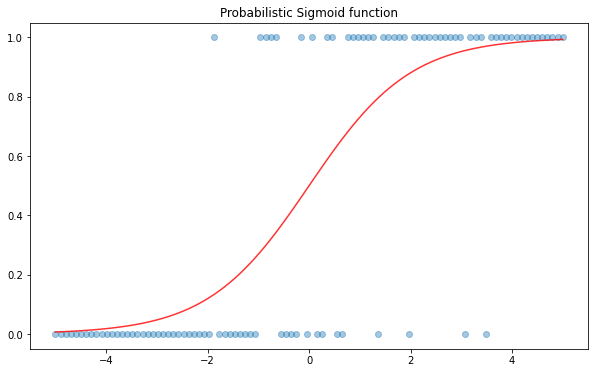

In [24]:
# Plot the probabilistic model
X = np.linspace(-5, 5, 100)
plt.scatter(X, model.predict(X), alpha=0.4)
plt.plot(X, 1 / (1 + np.exp(-X)), color='r', alpha=0.8)
plt.title('Probabilistic Sigmoid function')
plt.show()

In [25]:
# Create a constant input for this model
x = np.array([[0]])
x

array([[0]])

In [26]:
# Explore the feedforward object
y = model(x)
y

<tfp.distributions.Bernoulli 'probabilistic_sigmoid_model_distribution_lambda_1_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [27]:
# ... and its behavior under repeated calls
for _ in range(5):
    print(model.predict(x))

[[0]]
[[0]]
[[1]]
[[0]]
[[1]]


### Use the forward model to create probabilistic training data

In [28]:
# Use the model to create 500 training points
X_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(X_train)

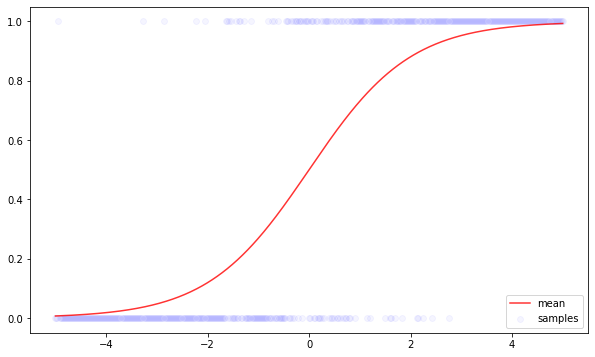

In [29]:
# Plot the data and the mean of the distribution
plt.scatter(X_train, y_train, alpha=0.04, color='blue', label='samples')
plt.plot(X_train, model(X_train).mean().numpy().flatten(), color='red', alpha=0.8, label='mean')
plt.legend(loc='best')
plt.show()

### Create a new probabilistic model with the wrong weights

In [30]:
model_untrained = Sequential([
    Dense(units=1, input_shape=(1, ), activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t:tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)
], name='wrong_probabilistic_model')

model.summary()

Model: "probabilistic_sigmoid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Train the new model with the negative log likelihoood

In [31]:
# Define negative log likelihood,
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [32]:
# Compile untrained model

model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=1e-2))

In [33]:
# Train the model, record weights after each epoch
epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]

for e in range(100):
    model_untrained.fit(X_train, y_train, epochs=1, verbose=False)
    epochs.append(e)
    
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

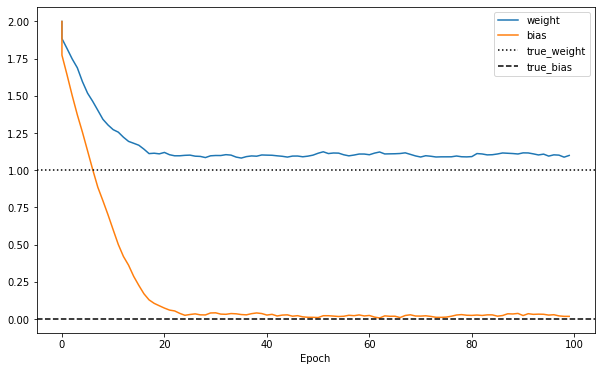

In [34]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

This make sense that the training data is not perfect. It contains some errors itself. This kind of uncertainty is called [epistemic uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty). We will cover it in later notebook.